<a href="https://colab.research.google.com/github/AmeerAliSaleem/isoc_tech_workshop_2024/blob/main/Warwick_ISoc_Tech_Project_Ghost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Warwick ISoc Tech Workshop 16/11/24: Project Ghost
---
* Overview of the task: we will build some NLP models to predict the sentiment of input texts, choosing from either positive, neutral or negative sentiment.
* For this mini-project, we will be using the following Kaggle dataset of tweet data: https://www.kaggle.com/datasets/abhi8923shriv/sentiment-analysis-dataset/
* Performance metric of choice: accuracy (proportion of correctly classified tweets). There are plenty of other metrics to choose from (such as precision, recall, f1 score, etc.), the uses of which depend on the context of your data science problem.

Key thing to remind students of: there is no one-size-fits-all approach to machine learning.

## Imports
---

In [ ]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import random
import regex as re
import nltk
import joblib
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
train = pd.read_csv("https://github.com/AmeerAliSaleem/isoc_tech_workshop_2024/raw/refs/heads/main/train.csv", encoding='unicode_escape')
test = pd.read_csv("https://github.com/AmeerAliSaleem/isoc_tech_workshop_2024/raw/refs/heads/main/test.csv", encoding='unicode_escape')

In [ ]:
train.head()

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26


## Data Preprocessing
---
Before feeding the data into a model, we must first convert the data into a format that a computer can understand, i.e. numbers.

In [ ]:
df = train[['text', 'sentiment']]
df.head()

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative
...,...,...
27476,wish we could come see u on Denver husband l...,negative
27477,I`ve wondered about rake to. The client has ...,negative
27478,Yay good for both of you. Enjoy the break - y...,positive
27479,But it was worth it ****.,positive


In [ ]:
df['sentiment'].value_counts()

,count
sentiment,
neutral,11118
positive,8582
negative,7781


In [ ]:
sentiment_mapping = {
    "negative": 0,
    "neutral": 1,
    "positive": 2
}

df['sentiment'] = df['sentiment'].map(sentiment_mapping)
df

<ipython-input-26-ca2ef02b3bab>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentiment'] = df['sentiment'].map(sentiment_mapping)


,text,sentiment
0,"I`d have responded, if I were going",1
1,Sooo SAD I will miss you here in San Diego!!!,0
2,my boss is bullying me...,0
3,what interview! leave me alone,0
4,"Sons of ****, why couldn`t they put them on t...",0
...,...,...
27476,wish we could come see u on Denver husband l...,0
27477,I`ve wondered about rake to. The client has ...,0
27478,Yay good for both of you. Enjoy the break - y...,2
27479,But it was worth it ****.,2


Computers understand numbers, not words. As such, we require some method of converting each sentence into a numerical format. To achieve this, we aim to convert each sentence into a vector that can be passed onto our resultant models. We could naively make a new vector for each sentence, but this would be pointless without some encoding of the words included in each sentence. That is, we need to preserve the meaning of the sentences in some way during this vectorisation process.

There exist pre-trained word corpuses online in which each English word is projected into vector space. Crucially, words of similar meanings are clustered together in these vector spaces. For the sake of this notebook, we will be leveraging the Gensim Word2Vec corpus: https://radimrehurek.com/gensim/index.html

In [ ]:
import gensim
from gensim.models import word2vec
from gensim.models.word2vec import Word2Vec

import spacy
import string

import gensim.downloader as api
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [ ]:
wv = api.load('glove-twitter-50')

[==================================================] 100.0% 199.5/199.5MB downloaded


In [ ]:
print(wv)

KeyedVectors<vector_size=50, 1193514 keys>


In [ ]:
# some helper functions for later

def sent_vec(sent):
    """
    Function for converting tokenised sentences into a vector
    by taking the mean of the vectors for each word in the sentence.
    """
    vector_size = wv.vector_size
    wv_res = np.zeros(vector_size)

    ctr = 1
    for w in sent:
        if w in wv:
            ctr += 1
            wv_res += wv[w]
    wv_res = wv_res/ctr
    return wv_res




Before any vectorisation procedures, there are a few data cleaning steps to take care of:
* Removal of stopwords: getting rid of words like 'the', 'and', etc. will help the model focus on the words in each text that contribute meaningfully to the text's sentiment.
* Lemmatisation/stemming: words like 'jump', 'jumping' and 'jumped' are all technically different words but they essentially have the same meaning. We want our models to recognise them as effectively all the same word 'jump'. Don't worry, grammar is not a sticking point when it comes to traditional NLP.
* Tokenisation: the process of converting the remaining words into bite-size chunks ('tokens') will prime the Series of text data to be embedded into high dimensional space.

In [ ]:
nlp = spacy.load("en_core_web_sm")
stop_words = nlp.Defaults.stop_words

punctuations = string.punctuation

Note: the following code block will take a while to run as the tokeniser is applied to each row of data.

In [ ]:
def spacy_tokenizer(sentence):
    """
    Function for converting each sentence of words into a list of word tokens.
    Before this, stop words are removed and a brief lemmatisation procedure is also applied.
    """
    doc = nlp(sentence)

    # Lemmatisation and conversion to lower case
    mytokens = [word.lemma_.lower().strip() for word in doc ]

    # Removal of stop words
    mytokens = [word for word in mytokens if word not in stop_words and word not in punctuations ]

    return mytokens

df['text'] = df['text'].apply(str)

df['tokens'] = df['text'].apply(spacy_tokenizer)
df.head()

<ipython-input-61-51057af6f367>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'] = df['text'].apply(str)
<ipython-input-61-51057af6f367>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tokens'] = df['text'].apply(spacy_tokenizer)


,text,sentiment,tokens
0,"I`d have responded, if I were going",1,"[i`d, respond]"
1,Sooo SAD I will miss you here in San Diego!!!,0,"[sooo, sad, miss, san, diego]"
2,my boss is bullying me...,0,"[boss, bully, ...]"
3,what interview! leave me alone,0,"[interview, leave]"
4,"Sons of ****, why couldn`t they put them on t...",0,"[son, couldn`t, release, buy]"


Now for the sentence vector embeddings. There are many ways to achieve this. For each sentence, we will conduct the following: each token in the sentence will be converted into a high dimensional vector with Word2Vec. This will give us a list of vectors, from which we compute the average vector, and take that to be the vector of the overall sentence.

In [ ]:
df['vectors'] = df['tokens'].apply(sent_vec)
df.head()

<ipython-input-64-ae9aff5a3f20>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['vectors'] = df['tokens'].apply(sent_vec)


,text,sentiment,tokens,vec,vectors
0,"I`d have responded, if I were going",1,"[i`d, respond]","[0.5846999883651733, 0.49103501439094543, -0.4...","[0.5846999883651733, 0.49103501439094543, -0.4..."
1,Sooo SAD I will miss you here in San Diego!!!,0,"[sooo, sad, miss, san, diego]","[0.16032333175341287, 0.428380835801363, 0.356...","[0.16032333175341287, 0.428380835801363, 0.356..."
2,my boss is bullying me...,0,"[boss, bully, ...]","[0.3568333288033803, 0.5311500132083893, -0.13...","[0.3568333288033803, 0.5311500132083893, -0.13..."
3,what interview! leave me alone,0,"[interview, leave]","[0.1312536665548881, 0.4501099983851115, 0.213...","[0.1312536665548881, 0.4501099983851115, 0.213..."
4,"Sons of ****, why couldn`t they put them on t...",0,"[son, couldn`t, release, buy]","[-0.3156049996614456, 0.25286317575955763, -0....","[-0.3156049996614456, 0.25286317575955763, -0...."


Note: this is one of many different ways in which word embeddings can be created. Do some research and try other methods to evaluate which method will suit your use case the best.

In any case, we can now package up the training and testing sets:

In [ ]:
X = df['vectors'].to_list()
y = df['sentiment'].to_list()

Now we have our word embeddings saved in `X`, and the corresponding sentiment labels saved in `y`. For the sake of training our models, we need to split the data into a training set and a testing set.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

At long last, we're now ready for some modelling!

## Model 1: Random Forest
The random forest algorithm trains a collection of decision trees on the training data, then aggregates their classifications in a majority-vote fashion to produce its predictions. Standalone decision trees are prone to overfitting, and so this bagging ensemble technique aims to mitigate that from happening while maintaining model performance.

In [ ]:
model1 = RandomForestClassifier()
model1.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
y_pred = model1.predict(X_test)
acc1 = accuracy_score(y_test, y_pred)
cm1 = confusion_matrix(y_test, y_pred)

print(f"Accuracy achieved by random forest is {acc1}.")
# print("Confusion matrix:")
# print(cm1)

Accuracy achieved by random forest is 0.6165181007822449.
Confusion matrix:
[[ 754  674  128]
 [ 324 1588  312]
 [ 107  563 1047]]


We can plot a confusion matrix to analyse the distribution of predictions:

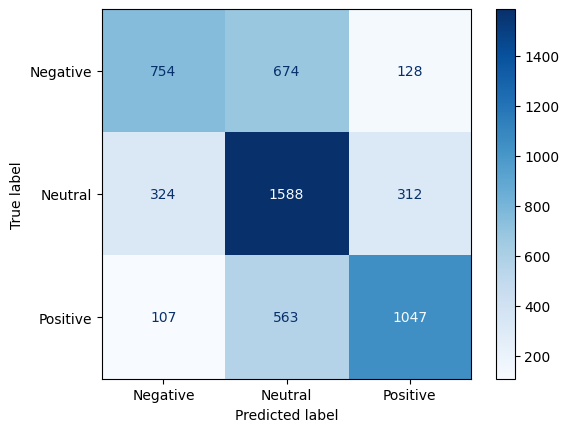

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=['Negative','Neutral','Positive'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

We can save this model so that it doesn't have to be trained from scratch all over again:

In [ ]:
joblib.dump(model1, 'random_forest_model.joblib')

['random_forest_model.joblib']

What do you think of the results? How could we improve them? A lot could be done in the data collection and cleaning steps. Assuming that we've done all we can for now, the final step would be to conduct some hyperparameter tuning.

### Hyperparameter Tuning
The random forest has its own set of arguments called hyperparameters. In order to fine-tune such a model, we can search through various combinations of hyperparameters to see which boasts the best performance on the test data.

There are a few ways in which this can be done, but since I'm feeling slightly lazy at this point in typing up this notebook, we ~cut and paste~ follow the guidance of https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
rf_random = RandomizedSearchCV(estimator = model1, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
15 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", li

KeyboardInterrupt: 

In [ ]:
y_pred_rf_random = rf_random.predict(X_test)
acc_rf_random = accuracy_score(y_test, y_pred_rf_random)
cm_rf_random = confusion_matrix(y_test, y_pred_rf_random)

print(f"Accuracy achieved by random forest is {acc_rf_random}.")
print("Confusion matrix:")
print(cm_rf_random)

In [ ]:
joblib.dump(rf_random, 'random_forest_tuned.joblib')

In [ ]:
# could also dump the models as pickle files
import pickle

with open('random_forest_model.pkl', 'wb') as file:
    pickle.dump(model1, file)

# with open('random_forest_tuned.pkl', 'wb') as file:
#     pickle.dump(rf_random, file)

## Model 2: Naive Bayes

## Model 3: Neural Network

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Extension: Using a Pre-trained Model

## Conclusion & Next Steps
---
Hope you enjoyed going through this notebook! Here are some things to think about:
1. In data science, there is no one-size-fits-all approach. Try a few different methods and see which produces the best results for you.
2. Garbage in, garbage out: data cleaning is a biiggggg part of the job. No matter how good your model, it cannot yield decent performance in the presence of low-quality data.
3. Try to enjoy the process. Stuff will break, weird errors will be thrown, and you may be left bashing your head against a wall at times. Patience will take you a lot further in your data career than anything else.
4. Ask for help when you get stuck :) I am not going to tell you to rely on ChatGPT, but I am also not _not_ going to tell you to rely on ChatGPT.

Our work here is far from done! Once you're satisfied with one of these models, save them and work with the Ghost DevOps team to get your predictor into production. You could use the model on comments left on blog posts to inform blog writers about how their content is being received. Don't stop there: could this feedback be built into an analytics dashboard? Could the data engineers support you in storing any relevant analytics and model training resources?


Don't forget to consult the ISoc Tech Notion page: https://silky-double-2ea.notion.site/Tech-Workshop-Resources-12f169d2bb7f80d19d11ea06067015d4?pvs=74